In [26]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
import re
import string
from wordcloud import WordCloud
from collections import Counter

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


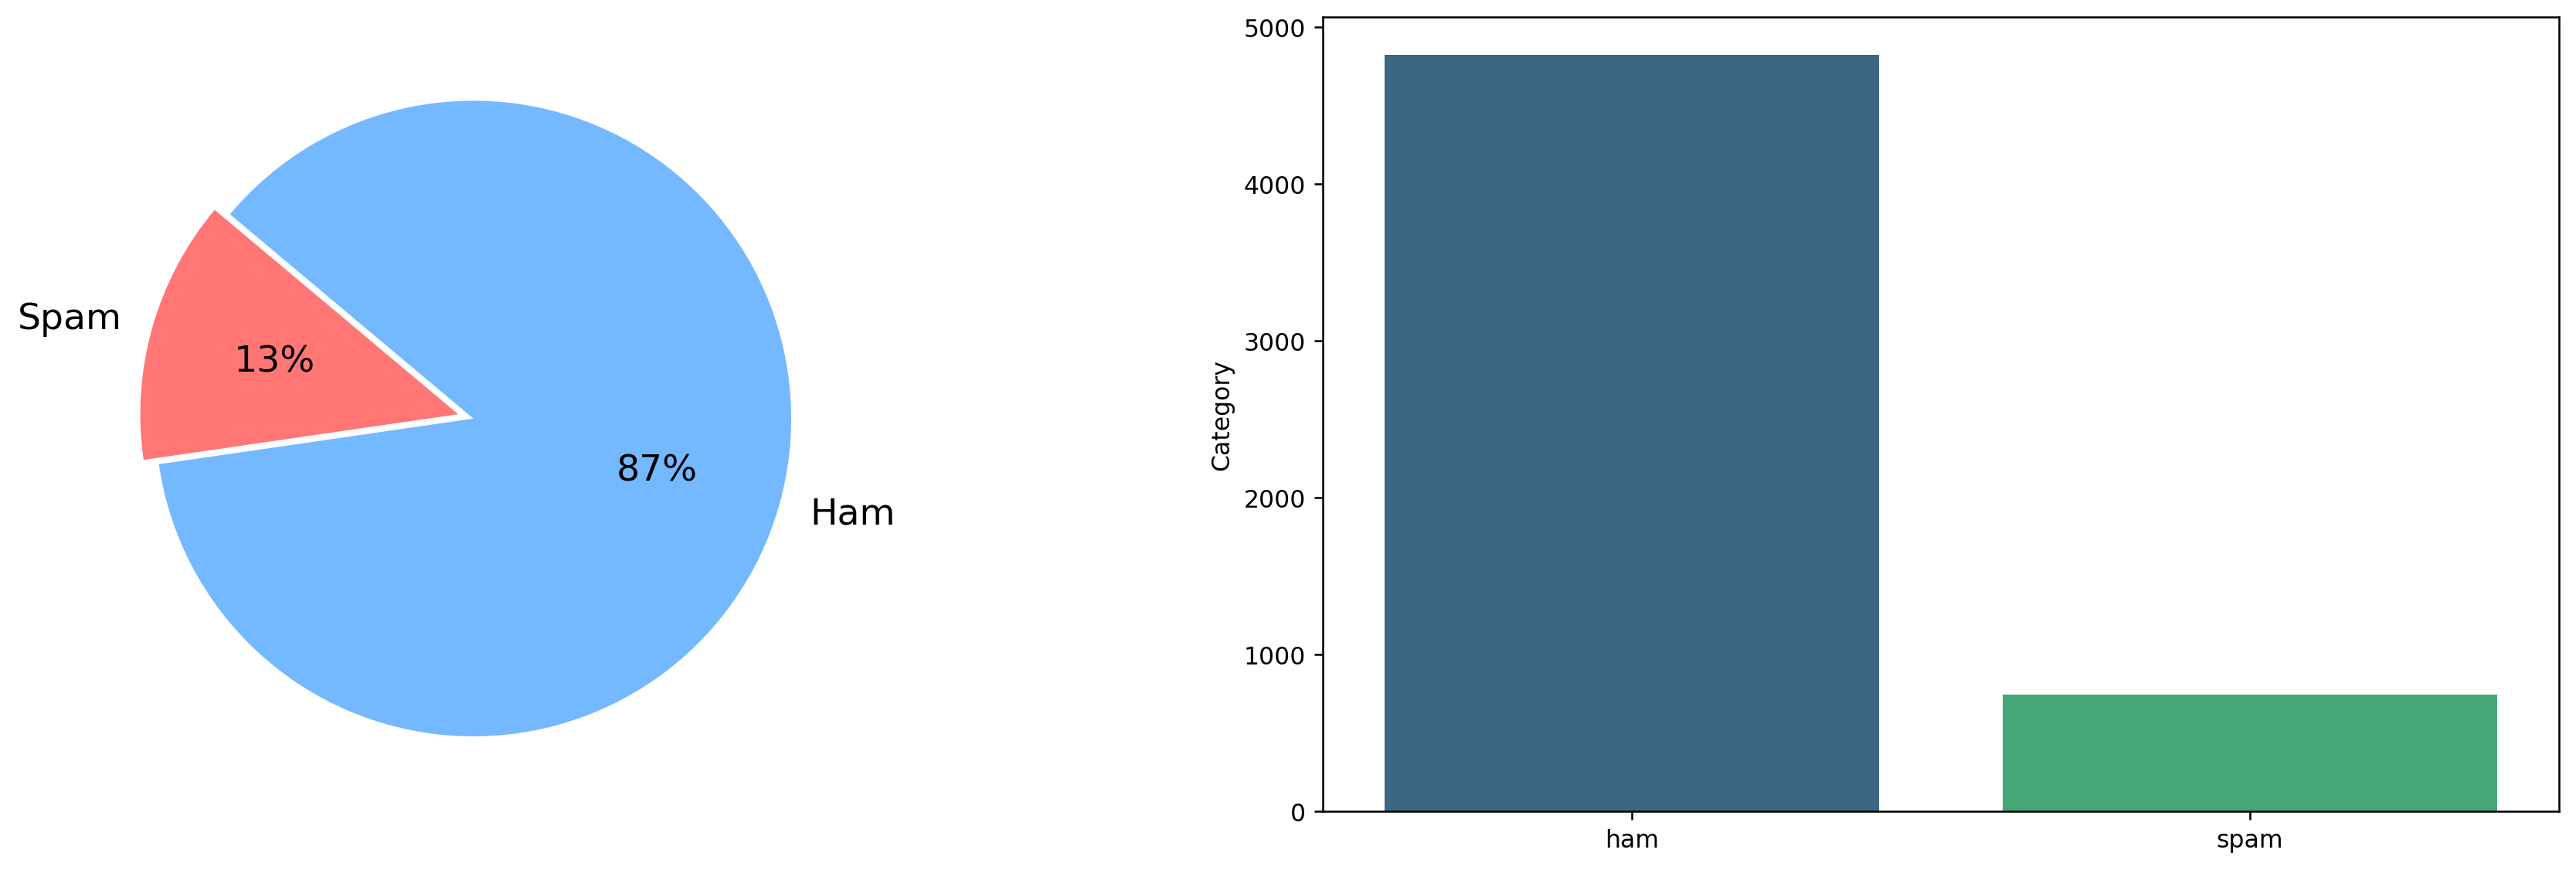

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# reading csv file and extracting class column to y.
data_set= pd.read_csv('/content/drive/MyDrive/data/SPAM text message 20170820 - Data.csv',encoding='utf-8')
data_set.head()
data_set.info()
data_set.shape
data_set['Category'].value_counts()
labels = ['Spam', 'Ham']
sizes = [747, 4825]
custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140,
        autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])
plt.subplot(1, 2, 2)
sns.barplot(x = data_set['Category'].unique(), y = data_set['Category'].value_counts(), palette=
'viridis')
plt.show()

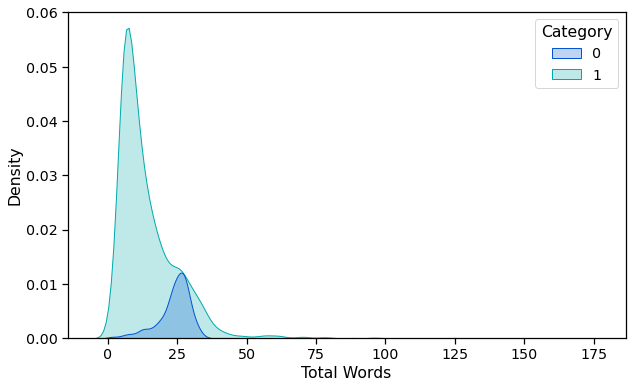

In [14]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data_set['Total Words'], hue= data_set['Category'], palette= 'winter', shade = True)
plt.show()

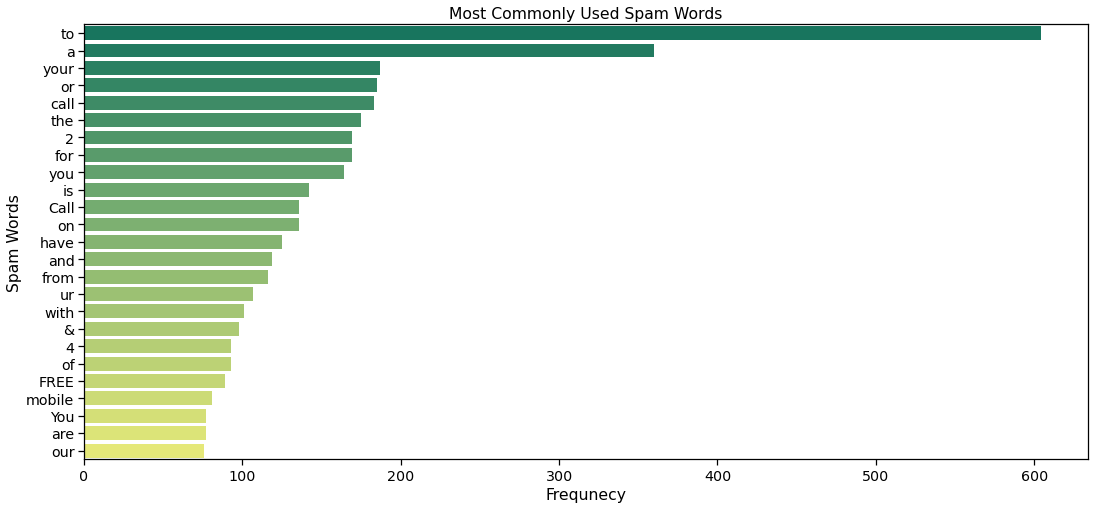

In [6]:
data_set['Total Words'] = data_set['Message'].apply(lambda x: len(x.split()))
def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char
data_set['Total Chars'] = data_set["Message"].apply(count_total_words)
data_set.head()

data_set['Category'] = data_set['Category'].replace({'spam':0,'ham':1})
all_spam_words = []
for sentence in data_set[data_set['Category'] == 0]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word','Frequency'])
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()

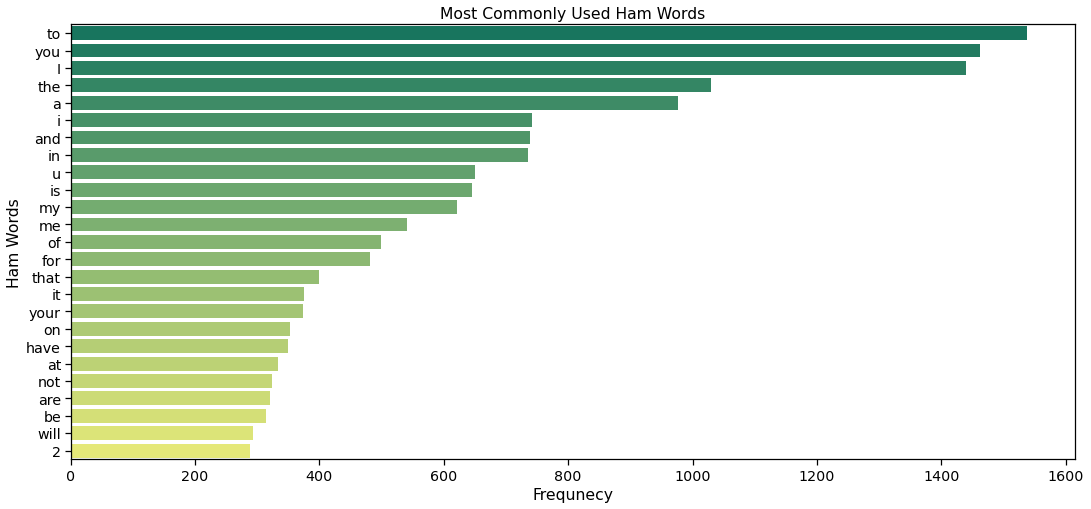

In [7]:
all_ham_words = []
for sentence in data_set[data_set['Category'] == 1]['Message'].to_list():
    for word in sentence.split():
        all_ham_words.append(word)
df = pd.DataFrame(Counter(all_ham_words).most_common(25), columns= ['Word','Frequency'])
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Ham Words")
plt.xlabel("Frequnecy")
plt.ylabel("Ham Words")
plt.show()

In [27]:
def convert_lowercase(text):
    text = text.lower()
    return text

data_set['Message'] = data_set['Message'].apply(convert_lowercase)

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data_set['Message'] = data_set['Message'].apply(remove_url)

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data_set['Message'] = data_set['Message'].apply(remove_punc)

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data_set['Message'] = data_set['Message'].apply(remove_stopwords)

def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data_set['Message'] = data_set['Message'].apply(perform_stemming)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(data_set['Message'], data_set['Category'],random_state=1)

cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)


Text(85.18, 0.5, 'predicted label')

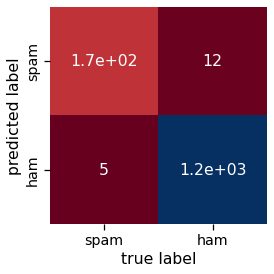

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['spam', 'ham'], yticklabels=['spam', 'ham'])
plt.xlabel('true label')
plt.ylabel('predicted label')


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))
print("F1 score: ",f1_score(y_test, predictions))

Accuracy score:  0.9877961234745154
Precision score:  0.9901234567901235
Recall score:  0.9958609271523179
F1 score:  0.9929839042509286
